In [24]:
import numpy as np
import sys
import torch, torchvision  
from skimage import io
from torch import nn
from torch.utils.data import DataLoader  
from torchvision.transforms import Compose, ToTensor, Normalize
sys.path.insert(0,'.')
import network
from datasets_chl import TrainDataset
from utils import (Nptranspose,Rotation,H_Mirror,V_Mirror)
import cal_acc
from sklearn.metrics import mean_squared_error  

In [31]:
def show_result(num_channels,model_path,image_dir,label_dir):
    model = None
    with open(model_path,'rb') as f:
        model = torch.load(f)
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)  
    model.eval()  # 设置模型为评估模式 
    # 准备数据  
    test_composed = torchvision.transforms.Compose([Nptranspose()])
    test_dataset = TrainDataset(num_channels,image_dir,label_dir,test_composed)
    test_dataloader = DataLoader(dataset = test_dataset, batch_size=1,num_workers=1,
                                  pin_memory=True,drop_last=True) 
    result = []
    with torch.no_grad():  # 不需要计算梯度  
        for index, sample in enumerate(test_dataloader): 
            image,label = sample['image'],sample['label']
            image = image.to(torch.float32)  # torch.float32
            label = label.to(torch.float32)
            image = image.to(device)
            label = label.to(device) 
            
            # 假设你的模型输出也是与targets相同形状的tensor  
            output,_,_,_ = model(image)
            output = output.cpu().numpy().astype('float32') * 255.0
            result.append(np.transpose(output[0],(1,2,0)))
    return result


In [32]:
model_3 = "model/seg=49_3.pkl"
model_4 = "model/seg49.pkl"
image = "../IEEE_data/dataset_show/image/"
label = "../IEEE_data/dataset_show/dsm/"
output_4 = show_result(4,model_4,image,label)
output_3 = show_result(3,model_3,image,label)
rgb, dsm, depth = [], [], []
import os
for file in os.listdir(image):
    file_name = file[:-4]
    image_path = image + file_name + ".npy"
    label_path = label + file_name + ".tif"
    image = np.load(image_path)
    image = np.transpose(image,(1,2,0))
    image = image.astype(np.float32)
    label = io.imread(label_path)
    label = np.reshape(label,(label.shape[0],label.shape[1],1))
    label = label.astype(np.float32)
    rgb.append(image[:, :, :3])
    depth.append(image[:, :, 3])
    dsm.append(label)

print(rgb[0].shape, dsm[0].shape, depth[0].shape ,output_3[0].shape, output_4[0].shape)

(512, 512, 3) (512, 512, 1) (512, 512) (512, 512, 1) (512, 512, 1)


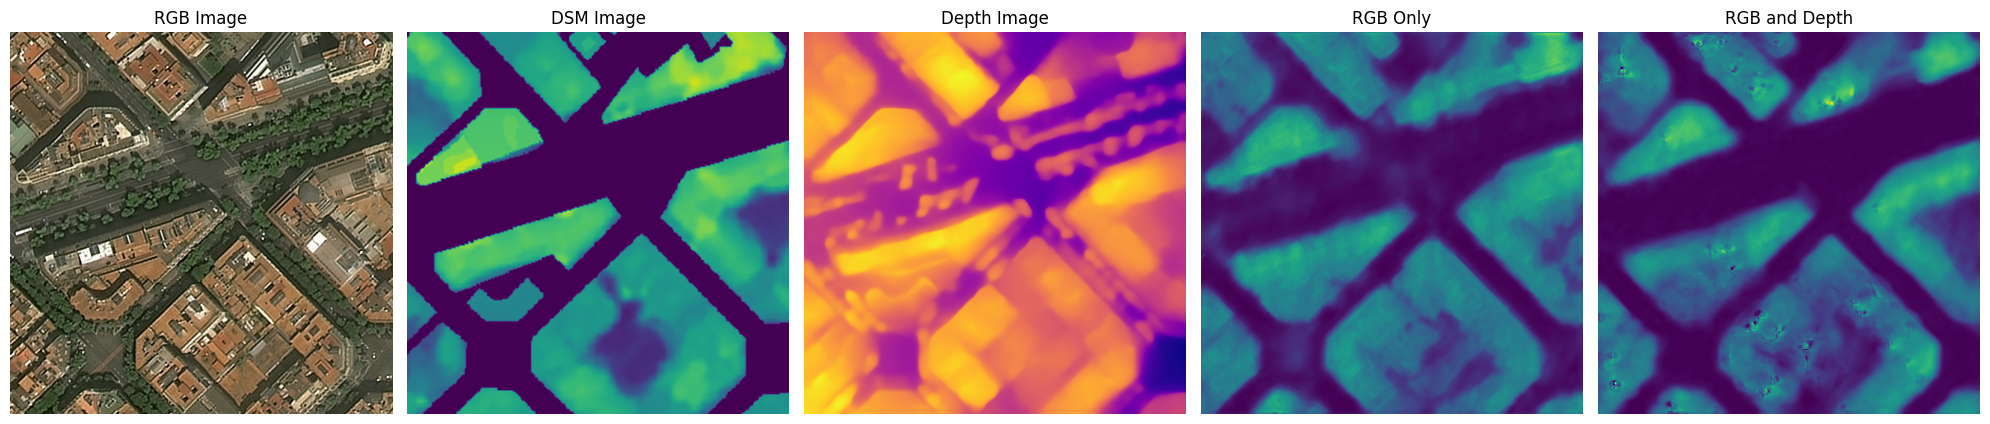

In [62]:
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolors

for i in range(len(rgb)):
    rgb_,dsm_,depth_ = rgb[i],dsm[i],depth[i] 
    output_3_,output_4_ = output_3[i],output_4[i]
    
    norm = mcolors.Normalize(vmin=np.min(dsm_), vmax=np.max(dsm_))  
    cmap = plt.get_cmap('viridis')
    fig, axs = plt.subplots(1, 5, figsize=(20, 5))  # 1行5列
    
    axs[0].imshow(rgb_/255.0)  
    axs[0].set_title('RGB Image')  
    axs[0].axis('off')  
    
    axs[1].imshow(dsm_,cmap=cmap, norm=norm)  
    axs[1].set_title('DSM Image')  
    axs[1].axis('off')  
    
    axs[2].imshow(depth_,cmap ='plasma' )  
    axs[2].set_title('Depth Image')  
    axs[2].axis('off')  
    
    axs[3].imshow(output_3_,cmap=cmap, norm=norm)  
    axs[3].set_title('RGB Only')  
    axs[3].axis('off')  
    
    axs[4].imshow(output_4_,cmap=cmap, norm=norm)  
    axs[4].set_title('RGB and Depth')  
    axs[4].axis('off')  
    
    # 显示图像  
    plt.tight_layout()  
    plt.show()

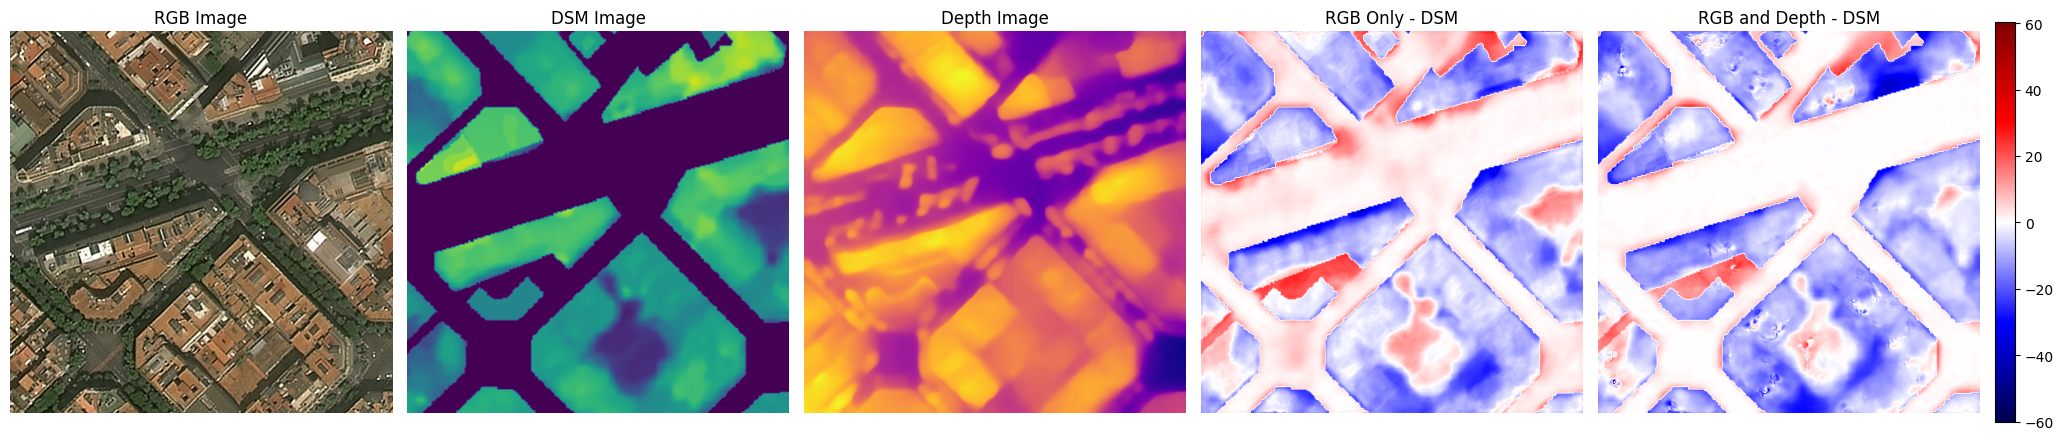

In [63]:
for i in range(len(rgb)):
    rgb_,dsm_,depth_ = rgb[i],dsm[i],depth[i] 
    output_3_,output_4_ = output_3[i]-dsm_,output_4[i]-dsm_
    
    vmax = np.max([np.max(output_3_),np.max(output_4_)])
    vmin = np.min([np.min(output_3_),np.min(output_4_)])
    vmax = np.max([abs(vmax),abs(vmin)])
    vmin = -vmax
    norm = mcolors.Normalize(vmin=vmin, vmax=vmax)  
    cmap = plt.get_cmap('seismic')
    fig, axs = plt.subplots(1, 5, figsize=(20, 5))  # 1行5列
    
    axs[0].imshow(rgb_/255.0)  
    axs[0].set_title('RGB Image')  
    axs[0].axis('off')   
    
    axs[1].imshow(dsm_)  
    axs[1].set_title('DSM Image')  
    axs[1].axis('off')   
    
    axs[2].imshow(depth_,cmap ='plasma')  
    axs[2].set_title('Depth Image')  
    axs[2].axis('off')
    
    im3 = axs[3].imshow(output_3_,cmap=cmap, norm=norm)  
    axs[3].set_title('RGB Only - DSM')  
    axs[3].axis('off')  
    
    im4 = axs[4].imshow(output_4_,cmap=cmap, norm=norm)  
    axs[4].set_title('RGB and Depth - DSM')  
    axs[4].axis('off') 
     
    cax = fig.add_axes([1, 0.1, 0.01, 0.8])
    fig.colorbar(im3, cax=cax)
    
    # 显示图像  
    plt.tight_layout()  
    plt.show()

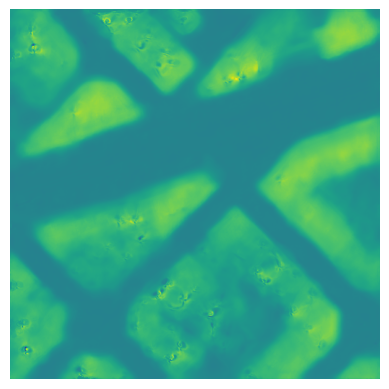

In [18]:
import matplotlib.pyplot as plt  
plt.imshow(output_4[0])  
plt.axis('off')  # 不显示坐标轴  
plt.show()